# Distributed mode superposition (MSUP) {#ref_distributed_msup}

This example shows how to read and expand distributed files on
distributed processes. The modal basis (two distributed files) is read
on two remote servers. The modal response is then read and expanded on a
third server.

The following diagram helps you to understand this example. It shows the
operator chain that is used to compute the final result.

::: graphviz

digraph foo {

:   graph \[pad=\"0\", nodesep=\"0.3\", ranksep=\"0.3\"\] node
    \[shape=box, style=filled, fillcolor=\"#ffcc00\", margin=\"0\"\];
    rankdir=LR; splines=line;

    disp01 \[label=\"displacement\"\]; disp02
    \[label=\"displacement\"\]; mesh01 \[label=\"mesh\"\]; mesh02
    \[label=\"mesh\"\];

    subgraph cluster_1 {

    :   ds01 \[label=\"data_src\", shape=box, style=filled,
        fillcolor=cadetblue2\];

        disp01; mesh01;

        ds01 -\> disp01 \[style=dashed\]; ds01 -\> mesh01
        \[style=dashed\];

        label=\"Server 1\"; style=filled; fillcolor=lightgrey;

    }

    subgraph cluster_2 {

    :   ds02 \[label=\"data_src\", shape=box, style=filled,
        fillcolor=cadetblue2\];

        disp02; mesh02;

        ds02 -\> disp02 \[style=dashed\]; ds02 -\> mesh02
        \[style=dashed\];

        label=\"Server 2\"; style=filled; fillcolor=lightgrey;

    }

    disp01 -\> \"merge_fields\"; mesh01 -\> \"merged_mesh\"; disp02 -\>
    \"merge_fields\"; mesh02 -\> \"merged_mesh\";

    ds03 \[label=\"data_src\", shape=box, style=filled,
    fillcolor=cadetblue2\]; ds03 -\> \"response\" \[style=dashed\];

    \"merged_mesh\" -\> \"response\"; \"response\" -\> \"expansion\";
    \"merge_fields\" -\> \"expansion\"; \"expansion\" -\> \"component\";

}
:::


Import the `dpf-core` module and its examples files.


In [1]:
import os
from ansys.dpf import core as dpf
from ansys.dpf.core import examples
from ansys.dpf.core import operators as ops

# Configure the servers

Make a list of IP addresses and port numbers that DPF servers start and
listen on. Operator instances are created on each of these servers so
that each server can address a different result file.

This example postprocesses an analysis distributed in two files.
Consequently, it requires two remote processes.

To make it easier, this example starts local servers. However, you can
connect to any existing servers on your network.


In [2]:
config = dpf.AvailableServerConfigs.InProcessServer
if "DPF_DOCKER" in os.environ.keys():
    # If running DPF on Docker, you cannot start an InProcessServer
    config = dpf.AvailableServerConfigs.GrpcServer
global_server = dpf.start_local_server(as_global=True, config=config)

remote_servers = [
    dpf.start_local_server(as_global=False, config=dpf.AvailableServerConfigs.GrpcServer),
    dpf.start_local_server(as_global=False, config=dpf.AvailableServerConfigs.GrpcServer),
]
ips = [remote_server.ip for remote_server in remote_servers]
ports = [remote_server.port for remote_server in remote_servers]

Print the IP addresses and ports.


In [3]:
print("ips:", ips)
print("ports:", ports)

ips: ['127.0.0.1', '127.0.0.1']
ports: [50054, 50055]


Specify the file path.


In [4]:
base_path = examples.find_distributed_msup_folder()

files = [
    dpf.path_utilities.join(base_path, "file0.mode"),
    dpf.path_utilities.join(base_path, "file1.mode"),
]
files_aux = [
    dpf.path_utilities.join(base_path, "file0.rst"),
    dpf.path_utilities.join(base_path, "file1.rst"),
]
files_rfrq = [
    dpf.path_utilities.join(base_path, "file_load_1.rfrq"),
]

# Create operators on each server

On each server, create two operators, one for displacement computations
and one for providing the mesh. Then, define their data sources. Both
the displacement operator and mesh provider operator receive data from
their respective data files on each server.


In [5]:
remote_displacement_operators = []
remote_mesh_operators = []
for i, server in enumerate(remote_servers):
    displacement = ops.result.displacement(server=server)
    mesh = ops.mesh.mesh_provider(server=server)
    remote_displacement_operators.append(displacement)
    remote_mesh_operators.append(mesh)
    ds = dpf.DataSources(files[i], server=server)
    ds.add_file_path(files_aux[i])
    displacement.inputs.data_sources(ds)
    mesh.inputs.data_sources(ds)

# Create a local operator chain for expansion

The following series of operators merge the modal basis and the meshes,
read the modal response, and expand the modal response with the modal
basis.


In [6]:
merge_fields = ops.utility.merge_fields_containers()
merge_mesh = ops.utility.merge_meshes()

ds = dpf.DataSources(files_rfrq[0])
response = ops.result.displacement(data_sources=ds)
response.inputs.mesh(merge_mesh.outputs.merges_mesh)

expansion = ops.math.modal_superposition(solution_in_modal_space=response, modal_basis=merge_fields)
component = ops.logic.component_selector_fc(expansion, 1)

# Connect the operator chains together and get the output


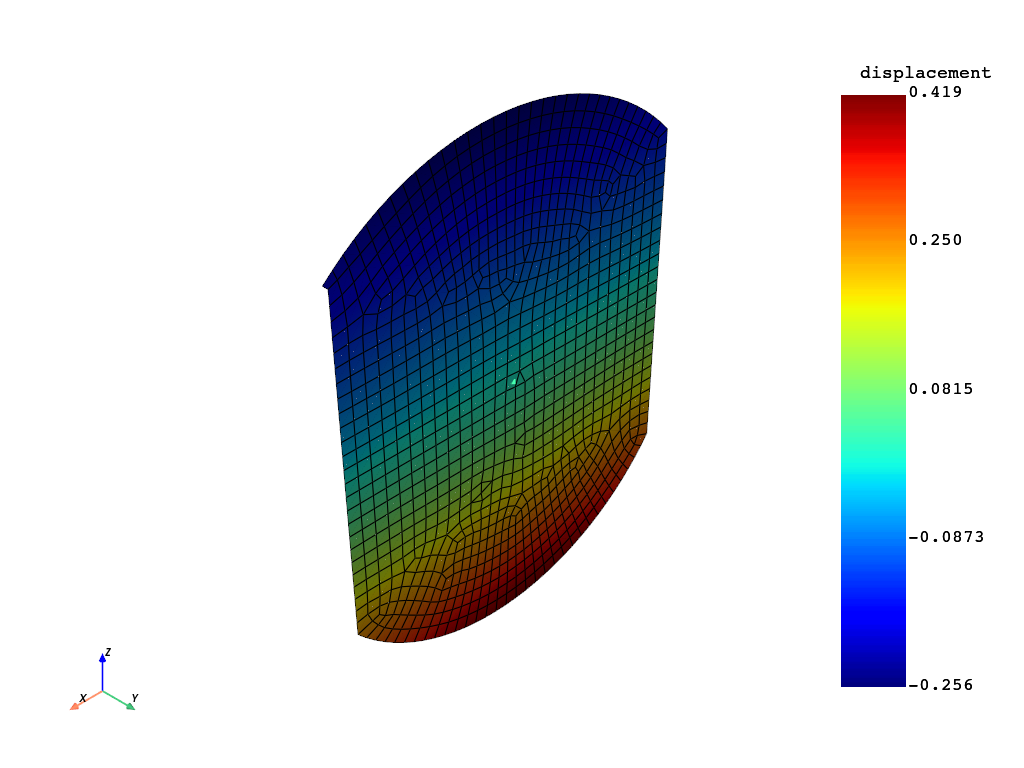

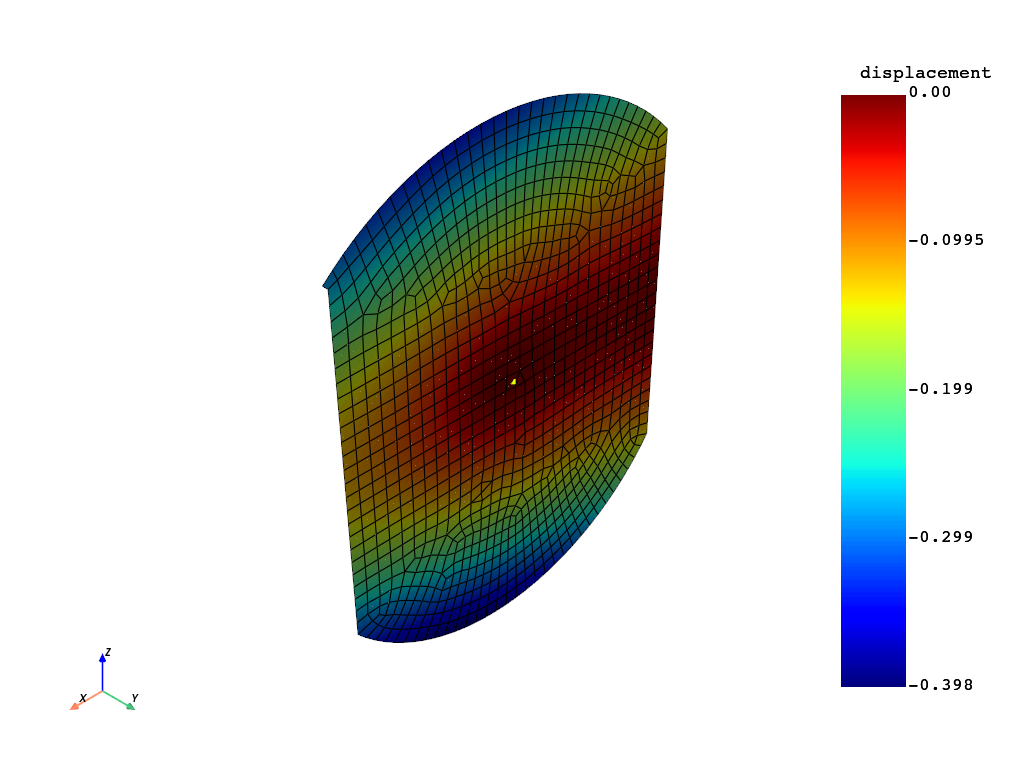

DPF  Fields Container
  with 20 field(s)
  defined on labels: complex time 

  with:
  - field 0 {complex:  0, time:  1} with Nodal location, 1 components and 1065 entities.
  - field 1 {complex:  1, time:  1} with Nodal location, 1 components and 1065 entities.
  - field 2 {complex:  0, time:  2} with Nodal location, 1 components and 1065 entities.
  - field 3 {complex:  1, time:  2} with Nodal location, 1 components and 1065 entities.
  - field 4 {complex:  0, time:  3} with Nodal location, 1 components and 1065 entities.
  - field 5 {complex:  1, time:  3} with Nodal location, 1 components and 1065 entities.
  - field 6 {complex:  0, time:  4} with Nodal location, 1 components and 1065 entities.
  - field 7 {complex:  1, time:  4} with Nodal location, 1 components and 1065 entities.
  - field 8 {complex:  0, time:  5} with Nodal location, 1 components and 1065 entities.
  - field 9 {complex:  1, time:  5} with Nodal location, 1 components and 1065 entities.
  - field 10 {complex:  0

In [7]:
for i, server in enumerate(remote_servers):
    merge_fields.connect(i, remote_displacement_operators[i], 0)
    merge_mesh.connect(i, remote_mesh_operators[i], 0)

fc = component.get_output(0, dpf.types.fields_container)
merged_mesh = merge_mesh.get_output(0, dpf.types.meshed_region)

merged_mesh.plot(fc.get_field_by_time_complex_ids(1, 0))
merged_mesh.plot(fc.get_field_by_time_complex_ids(10, 0))
print(fc)